*2017.09.19*

1. DQN (Deep Q-Network)
1. DQNの改良
1. A3C (Asynchronous Advantage Actor-Critic)

---

**1. DQN（Deep Q-Network）**

---

**強化学習**

* エージェントは時刻 $t$ の状態 $s_t$ において, 政策 $\pi$ にしたがって行動 $a_t$ を選択し, 次の状態 $s_{t+1}$ に遷移して, 報酬 $r_{t+1}$ を得る.  
→ 累積報酬 $\Sigma^{T}_{k=0}r_{t+k+1}$ の最大化が目標.  
→ 期待累積報酬を最大化する最適政策 $\pi^{*}$ を求める.  
→ $\pi$ にしたがった時の期待累積報酬を表す行動価値関数 $Q_{\pi}$ の最適関数 $Q^{*}$ を求めることで, $\pi^{*}(s)=\arg\max_aQ^{*}(s, a)$ が求まる.

$\mathcal{S}=\{s_1, s_2, ..., s_m\}$: 状態空間（環境がとりうる状態の集合）  
$\mathcal{A}=\{a_1, a_2, ..., a_n\}$: 行動空間（エージェントがとりうる行動の集合）  
$\pi(s, a)=P(a_t=a|s_t=s)$: 政策  
$r_{t+1}=r(s_t, a_t)\in\mathcal{R}$: 報酬関数  
$Q_{\pi}(s, a)=E_{\pi}\left[\Sigma^{\infty}_{k=0}\gamma^{k}r_{t+k+1}|s_t=s, a_t=a\right]$: 行動価値関数

---

**Q-learning**

* 強化学習の代表的手法
* 行動価値関数 $Q$ で価値の高い行動を選択し, 状態・報酬の観測を繰り返すことで, 次の状態での $Q$ の値と現時点での $Q$ の値の間に生じるTD誤差を使って, 最適な行動価値関数を推定する.

$Q(s_t, a_t){\leftarrow}Q(s_t, a_t)+\alpha\left\{r_{t+1}+\gamma\max_{a_{t+1}}Q(s_{t+1}, a_{t+1})-Q(s_t, a_t)\right\}$

---

**DQN（Deep Q-Network）**

* [V. Mnih, K. Kavukcuoglu, D. Silver, A. Graves, I. Antonglou, D. Wierstra, and M. Riedmiller, Playing Atari with Deep Reinforcement Learning, NIPS 2013 Deep Learning Workshop, 2013.](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
* $Q$ をテーブルではなく関数（深層学習）で近似する.  
（状態$\times$行動を入力とするのではなく, 状態を入力して行動の $Q$ 値を出力するネットワークを構成する）
* $Q(s_t,a_t)$ を $r+\gamma\max_{a_{t+1}}Q(s_{t+1},a_{t+1})$ に近づけるために, 後者を教師信号として現在の $Q$ との誤差関数 $L(s,a)$ を使って学習させる.
* 様々な工夫（Experience replay, Freezing the target network, Clipping rewards, Skipping frames）

$target\hspace{.5em}\equiv\hspace{.5em}r+\gamma\max_{a_{t+1}}Q(s_{t+1},a_{t+1})$  
$L(s,a)\hspace{.5em}\equiv\hspace{.5em}\frac{1}{2}\left(target-Q(s,a)\right)^2$

---

**Experience replay**

* 経験は時系列に獲得する. i.i.d.ではない. 経験に相関があるとネットワークが過学習してしまう.  
→ 保存した経験からランダムに選んで学習させる.

$Memory = \{(s_t, a_t, s_{t+1}, r_{t+1}), (s_{t+1}, a_{t+1}, s_{t+2}, r_{t+2}), \ldots\}$  
→ $Memory$ からミニバッチサイズ分, ランダムに選んで学習.  
→ 相関がなくなり, 安定かつ高速に学習.

---

**Freezing the target network**

* TD誤差の目標値に古い $Q$ （target $Q$-network）を使う.

$target\hspace{.5em}\equiv\hspace{.5em}r+\gamma\max_{a_{t+1}}Q_{\theta^{-1}}(s_{t+1},a_{t+1})$  
$L_\theta(s,a)\hspace{.5em}\equiv\hspace{.5em}\frac{1}{2}\left(target-Q_{\theta}(s,a)\right)^2$  
一定周期で学習中の $Q_\theta$ のパラメータと同期: $\theta^{-1}\leftarrow\theta$

---

**Clipping rewards**

* ゲームにより, スコア（報酬）の大きさが異なると, ハイパーパラメータを調整する必要がある.  
  → 報酬のスケールを統一する.
  
正スコア: $+1$  
負スコア: $-1$

---

**Skipping frames**

* 毎フレームで行動選択を行うと計算コストがかかる上, そもそも毎フレームで行動する必要はない.  
→ 数フレームごとに行動を選択する.  
→ 行動選択のコストが減り, 多くの経験を学習することができる.

In [5]:
import copy
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
from gym import wrappers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# ライブラリの確認
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print('-'*30)
libs = ["numpy", "matplotlib", "gym", "torch", "torchvision"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)
print("")

# 環境の確認
env = gym.make("CartPole-v0")
print("observation space num: {}".format(env.observation_space.shape[0]))
print("action space num: {}".format(env.action_space.n))

pobs = env.reset()
done = False
while not done:
    act = env.action_space.sample()
    obs, reward, done, _ = env.step(act)
    print(pobs, act, reward, obs, done)
    pobs = obs

python 3.6.6
------------------------------
numpy 1.14.5
matplotlib 2.1.0
gym 0.10.5
torch 0.4.0
torchvision 0.2.1

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space num: 4
action space num: 2
[ 0.01090495 -0.00119962 -0.01414815 -0.04377298] 1 1.0 [ 0.01088096  0.19412232 -0.01502361 -0.34088598] False
[ 0.01088096  0.19412232 -0.01502361 -0.34088598] 1 1.0 [ 0.0147634   0.38945477 -0.02184132 -0.63826837] False
[ 0.0147634   0.38945477 -0.02184132 -0.63826837] 0 1.0 [ 0.0225525   0.19464407 -0.03460669 -0.35254286] False
[ 0.0225525   0.19464407 -0.03460669 -0.35254286] 1 1.0 [ 0.02644538  0.39024061 -0.04165755 -0.65593433] False
[ 0.02644538  0.39024061 -0.04165755 -0.65593433] 0 1.0 [ 0.03425019  0.1957226  -0.05477624 -0.37665423] False
[ 0.03425019  0.1957226  -0.05477624 -0.37665423] 0 1.0 [ 0.03816465  0.00141969 -0.06230932 -0.10173316] False
[ 0.03816465  0.00141969 -0.06230932 -0.10173316] 1 1.0 [ 0.03819304

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
epoch	EPSILON	reward	total_step	elapsed_time
100	0.0999999999999992	11.8	1380	1.3779709339141846[sec]
200	0.0999999999999992	8.2	2400	1.2122108936309814[sec]
300	0.0999999999999992	14.17	4017	1.9436275959014893[sec]
400	0.0999999999999992	20.61	6278	2.6903586387634277[sec]
500	0.0999999999999992	39.27	10405	4.74548602104187[sec]
600	0.0999999999999992	111.88	21793	14.002873182296753[sec]
700	0.0999999999999992	78.43	29836	10.168601751327515[sec]
800	0.0999999999999992	129.71	43007	15.861029386520386[sec]
900	0.0999999999999992	119.1	55117	15.753166437149048[sec]
1000	0.0999999999999992	156.13	70930	20.476444482803345[sec]


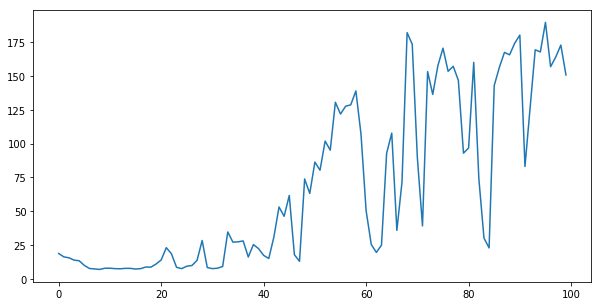

In [8]:
# DQN, PyTorch, CartPole

# 環境
MONITOR = False
env = gym.make("CartPole-v0")
if MONITOR:
    env = wrappers.Monitor(env, "./result", force=True,  video_callable=lambda episode_id: episode_id%100==0)

obs_num = env.observation_space.shape[0]
acts_num = env.action_space.n
HIDDEN_SIZE = 100

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(obs_num, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc4 = nn.Linear(HIDDEN_SIZE, acts_num)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        y = F.relu(self.fc4(h))
        return y

# 定数
EPOCH_NUM = 1000 # エポック数
STEP_MAX = 200 # 最高ステップ数
MEMORY_SIZE = 200 # メモリサイズいくつで学習を開始するか
BATCH_SIZE = 50 # バッチサイズ
EPSILON = 1.0 # ε-greedy法
EPSILON_DECREASE = 0.001 # εの減少値
EPSILON_MIN = 0.1 # εの下限
START_REDUCE_EPSILON = 200 # εを減少させるステップ数
TRAIN_FREQ = 10 # Q関数の学習間隔
UPDATE_TARGET_Q_FREQ = 20 # Q関数の更新間隔
GAMMA = 0.97 # 割引率
LOG_FREQ = 100 # ログ出力の間隔

# モデル
Q = NN() # 近似Q関数
Q_ast = copy.deepcopy(Q)
optimizer = optim.RMSprop(Q.parameters(), lr=0.00015, alpha=0.95, eps=0.01)

total_step = 0 # 総ステップ（行動）数
memory = [] # メモリ
total_rewards = [] # 累積報酬記録用リスト

# 学習開始
print("\t".join(["epoch", "EPSILON", "reward", "total_step", "elapsed_time"]))
start = time.time()
for epoch in range(EPOCH_NUM):
    pobs = env.reset() # 環境初期化
    step = 0 # ステップ数
    done = False # ゲーム終了フラグ
    total_reward = 0 # 累積報酬
    while not done and step < STEP_MAX:
        if MONITOR:
            env.render()
        # 行動選択
        pact = env.action_space.sample()
        # ε-greedy法
        if np.random.rand() > EPSILON:
            # 最適な行動を予測
            pobs_ = np.array(pobs, dtype="float32").reshape((1, obs_num))
            pobs_ = Variable(torch.from_numpy(pobs_))
            pact = Q(pobs_)
            maxs, indices = torch.max(pact.data, 1)
            pact = indices.numpy()[0]
        # 行動
        obs, reward, done, _ = env.step(pact)
        if done:
            reward = -1
        # メモリに蓄積
        memory.append((pobs, pact, reward, obs, done)) # 状態、行動、報酬、行動後の状態、ゲーム終了フラグ
        if len(memory) > MEMORY_SIZE: # メモリサイズを超えていれば消していく
            memory.pop(0)
        # 学習
        if len(memory) == MEMORY_SIZE: # メモリサイズ分溜まっていれば学習
            # 経験リプレイ
            if total_step % TRAIN_FREQ == 0:
                memory_ = np.random.permutation(memory)
                memory_idx = range(len(memory_))
                for i in memory_idx[::BATCH_SIZE]:
                    batch = np.array(memory_[i:i+BATCH_SIZE]) # 経験ミニバッチ
                    pobss = np.array(batch[:,0].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_num))
                    pacts = np.array(batch[:,1].tolist(), dtype="int32")
                    rewards = np.array(batch[:,2].tolist(), dtype="int32")
                    obss = np.array(batch[:,3].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_num))
                    dones = np.array(batch[:,4].tolist(), dtype="bool")
                    # set y
                    pobss_ = Variable(torch.from_numpy(pobss))
                    q = Q(pobss_)
                    obss_ = Variable(torch.from_numpy(obss))
                    maxs, indices = torch.max(Q_ast(obss_).data, 1)
                    maxq = maxs.numpy() # maxQ
                    target = copy.deepcopy(q.data.numpy())
                    for j in range(BATCH_SIZE):
                        target[j, pacts[j]] = rewards[j]+GAMMA*maxq[j]*(not dones[j]) # 教師信号
                    # Perform a gradient descent step
                    optimizer.zero_grad()
                    loss = nn.MSELoss()(q, Variable(torch.from_numpy(target)))
                    loss.backward()
                    optimizer.step()
            # Q関数の更新
            if total_step % UPDATE_TARGET_Q_FREQ == 0:
                Q_ast = copy.deepcopy(Q)
        # εの減少
        if EPSILON > EPSILON_MIN and total_step > START_REDUCE_EPSILON:
            EPSILON -= EPSILON_DECREASE
        # 次の行動へ
        total_reward += reward
        step += 1
        total_step += 1
        pobs = obs
    total_rewards.append(total_reward) # 累積報酬を記録
    if (epoch+1) % LOG_FREQ == 0:
        r = sum(total_rewards[((epoch+1)-LOG_FREQ):(epoch+1)])/LOG_FREQ # ログ出力間隔での平均累積報酬
        elapsed_time = time.time()-start
        print("\t".join(map(str,[epoch+1, EPSILON, r, total_step, str(elapsed_time)+"[sec]"]))) # ログ出力
        start = time.time()
if MONITOR:
    env.render(close=True)
    
total_rewards_dqn = total_rewards
plt.figure(figsize=(10,5))
resize = (len(total_rewards)//10, 10)
tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp)
plt.show()

**2. DQNの改良**

---

**Double DQN**

* [H. van Hasselt, A. Guez, and D. Silver, Deep reinforcement learning with double q-learning, arXiv, 2015.](https://arxiv.org/pdf/1509.06461.pdf)
* DQNでは, TD誤差計算時に目標値に大きすぎる値が設定されると, 前の状態を過大評価してしまう.  
→ 2つの $Q$ 関数を混ぜて学習.  
→ DQNにおける教師信号出力用のネットワークを $Q_{\theta^{-1}}$, そのコピーを $Q_\theta$ とすると, $s_{t+1}$ でとるべき行動を $Q_\theta$ で決定し, その評価値を $Q_{\theta^{-1}}$ で出力して $Q_\theta$ を更新する.  
→ TD誤差の計算が安定.

$target\hspace{.2em}\equiv\hspace{.2em}r+{\gamma}Q_{\theta^{-1}}(s_{t+1},\arg\max_{a_{t+1}}Q_\theta(s_{t+1},a_{t+1}))$

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Train
epoch	EPSILON	reward	total_step	elapsed_time
100	0.0999999999999992	12.01	1401	0.9192342758178711[sec]
200	0.0999999999999992	8.79	2480	0.8488254547119141[sec]
300	0.0999999999999992	10.18	3698	0.958500862121582[sec]
400	0.0999999999999992	19.32	5830	2.5589911937713623[sec]
500	0.0999999999999992	34.73	9503	4.565944671630859[sec]
600	0.0999999999999992	85.71	18274	11.722423315048218[sec]
700	0.0999999999999992	43.46	22820	5.833068609237671[sec]
800	0.0999999999999992	165.32	39552	20.96989870071411[sec]
900	0.0999999999999992	151.36	54888	21.124531984329224[sec]
1000	0.0999999999999992	143.27	69415	20.501830577850342[sec]


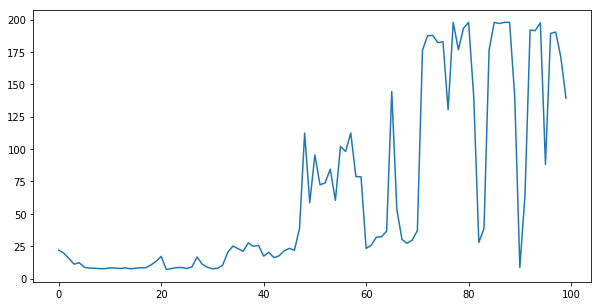

In [9]:
# Double DQN, PyTorch, CartPole 

# 環境
MONITOR = False
env = gym.make("CartPole-v0")
if MONITOR:
    env = wrappers.Monitor(env, "./result", force=True, video_callable=lambda episode_id: episode_id%100==0)

obs_num = env.observation_space.shape[0]
acts_num = env.action_space.n
HIDDEN_SIZE = 100

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(obs_num, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc4 = nn.Linear(HIDDEN_SIZE, acts_num)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        y = F.relu(self.fc4(h))
        return y

# 定数
EPOCH_NUM = 1000 # エポック数
STEP_MAX = 200 # 最高ステップ数
MEMORY_SIZE = 200 # メモリサイズいくつで学習を開始するか
BATCH_SIZE = 50 # バッチサイズ
EPSILON = 1.0 # ε-greedy法
EPSILON_DECREASE = 0.001 # εの減少値
EPSILON_MIN = 0.1 # εの下限
START_REDUCE_EPSILON = 200 # εを減少させるステップ数
TRAIN_FREQ = 10 # Q関数の学習間隔
UPDATE_TARGET_Q_FREQ = 20 # Q関数の更新間隔
GAMMA = 0.97 # 割引率
LOG_FREQ = 100 # ログ出力の間隔

# モデル
Q = NN() # 近似Q関数
Q_ast = copy.deepcopy(Q)
optimizer = optim.RMSprop(Q.parameters(), lr=0.00015, alpha=0.95, eps=0.01)

total_step = 0 # 総ステップ（行動）数
memory = [] # メモリ
total_rewards = [] # 累積報酬記録用リスト

# 学習開始
print("Train")
print("\t".join(["epoch", "EPSILON", "reward", "total_step", "elapsed_time"]))
start = time.time()
for epoch in range(EPOCH_NUM):
    pobs = env.reset() # 環境初期化
    step = 0 # ステップ数
    done = False # ゲーム終了フラグ
    total_reward = 0 # 累積報酬
    while not done and step < STEP_MAX:
        if MONITOR:
            env.render()
        # 行動選択
        pact = env.action_space.sample()
        # ε-greedy法
        if np.random.rand() > EPSILON:
            # 最適な行動を予測
            pobs_ = np.array(pobs, dtype="float32").reshape((1, obs_num))
            pobs_ = Variable(torch.from_numpy(pobs_))
            pact = Q(pobs_)
            maxs, indices = torch.max(pact.data, 1)
            pact = indices.numpy()[0]
        # 行動
        obs, reward, done, _ = env.step(pact)
        if done:
            reward = -1
        # メモリに蓄積
        memory.append((pobs, pact, reward, obs, done)) # 状態、行動、報酬、行動後の状態、ゲーム終了フラグ
        if len(memory) > MEMORY_SIZE: # メモリサイズを超えていれば消していく
            memory.pop(0)
        # 学習
        if len(memory) == MEMORY_SIZE: # メモリサイズ分溜まっていれば学習
            # 経験リプレイ
            if total_step % TRAIN_FREQ == 0:
                memory_ = np.random.permutation(memory)
                memory_idx = range(len(memory_))
                for i in memory_idx[::BATCH_SIZE]:
                    batch = np.array(memory_[i:i+BATCH_SIZE]) # 経験ミニバッチ
                    pobss = np.array(batch[:,0].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_num))
                    pacts = np.array(batch[:,1].tolist(), dtype="int32")
                    rewards = np.array(batch[:,2].tolist(), dtype="int32")
                    obss = np.array(batch[:,3].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_num))
                    dones = np.array(batch[:,4].tolist(), dtype="bool")
                    # set y_doubleq
                    pobss_ = Variable(torch.from_numpy(pobss))
                    q = Q(pobss_)
                    maxs, indices = torch.max(q.data, 1)
                    indices = indices.numpy()
                    obss_ = Variable(torch.from_numpy(obss))
                    maxqs = Q_ast(obss_).data.numpy() # ここからindiciesの行動の評価値で更新する
                    target = copy.deepcopy(q.data.numpy())
                    for j in range(BATCH_SIZE):
                        target[j, pacts[j]] = rewards[j]+GAMMA*maxqs[j, indices[j]]*(not dones[j]) # 教師信号
                    # Perform a gradient descent step
                    optimizer.zero_grad()
                    loss = nn.MSELoss()(q, Variable(torch.from_numpy(target)))
                    loss.backward()
                    optimizer.step()
            # Q関数の更新
            if total_step % UPDATE_TARGET_Q_FREQ == 0:
                Q_ast = copy.deepcopy(Q)
        # εの減少
        if EPSILON > EPSILON_MIN and total_step > START_REDUCE_EPSILON:
            EPSILON -= EPSILON_DECREASE
        # 次の行動へ
        total_reward += reward
        step += 1
        total_step += 1
        pobs = obs
    total_rewards.append(total_reward) # 累積報酬を記録
    if (epoch+1) % LOG_FREQ == 0:
        r = sum(total_rewards[((epoch+1)-LOG_FREQ):(epoch+1)])/LOG_FREQ # ログ出力間隔での平均累積報酬
        elapsed_time = time.time()-start
        print("\t".join(map(str,[epoch+1, EPSILON, r, total_step, str(elapsed_time)+"[sec]"]))) # ログ出力
        start = time.time()
if MONITOR:
    env.render(close=True)
    
total_rewards_ddqn = total_rewards
plt.figure(figsize=(10,5))
resize = (len(total_rewards)//10, 10)
tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp)
plt.show()

---

**Dueling Double DQN**

* [Z. Wang, N. de Freitas, and M. Lanctot, Dueling Network Architectures for Deep Reinforcement Learning, arXiv, 2015.](https://arxiv.org/abs/1511.06581)
* $Q$ 関数だと, 1回の更新で1つの行動に対する価値しか更新できない.  
→ $Q$ 関数を状態価値関数 $V(s)$ とAdvantage（行動優位）関数 $A(s, a)$ に分解して学習させる.  
→ $V$を毎回更新できる. TD誤差の計算の伝播が早くなる.

$Q_\theta(s_t, a_t)=V_{\theta,\beta}(s_t)+\left(A_{\theta,\alpha}(s_t, a_t)+\frac{1}{|\mathcal{A}|}\Sigma_{a_{t+1}}A_{\theta,\alpha}(s_t, a_{t+1})\right)$

---

**Prioritized Experience Replay** 

* [T. Schaul, J. Quan, I. Antonoglou, and D. Silver, Prioritized Experience Replay, arXiv, 2015.](https://arxiv.org/abs/1511.05952)
* DQNでは経験からランダムに選んで学習している.  
→ より学習に役立つ経験を優先して学習させたい.  
→ 経験サンプルの重要性 $p_i$ をTD誤差の絶対値 $|\delta_i|$ （パラメータの更新幅とみなせる）を用いて表し, 確率とした上でサンプリングする.  
→ TD誤差の大きい経験を優先して学習させられる.

$P(i)=\frac{p_i^\alpha}{\Sigma_kp_k^\alpha},\hspace{1em}p_i=|\delta_i|+\epsilon$

---

**Gorila DQN (GOogle ReInforcement Learning Architecture DQN)**

* [A. Nair, P. Srinivasan, S. Blackwell, C. Alcicek, R. Fearon, A. De Maria, M. Suleyman, C. Beattie, S. Petersen, S. Legg, V. Mnih, and D. Silver, Massively Parallel Methods for Deep Reinforcement Learning, ICML Deep Learning Workshop, 2015.](https://arxiv.org/abs/1507.04296)
* Memory（経験）を集めるActorと誤差計算を行うLearnerを並列分散処理させる.  
→ DQNよりも高速に学習した.

---

**3. A3C（Asynchronous Advantage Actor-Critic）**

---

**A3C（Asynchronous Advantage Actor-Critic）**

* [V. Mnih, A. P. Badia, M. Mirza, A. Graves, T. P. Lillicrap, T. Harley, D. Silver, and K. Kavukcuoglu, Asynchronous Methods for Deep Reinforcement Learning, arXiv, 2016.](https://arxiv.org/pdf/1602.01783.pdf)
* CPUのマルチスレッドで同時に複数のエージェントを学習.  
→ GPUを使ったDQNよりも早く学習できた.
* Asynchronous, Advantage, Actor-Critic

---

**Asynchronous**

* 各スレッドでローカルなエージェントを並列で走らせ, パラメータを非同期に更新する.


1. $\theta_{local}$（スレッドごとに別々のパラメータ）$\leftarrow$$\theta$（グローバルなパラメータ）（同期）
1. $\theta_{local}$ を使って勾配 $d\theta$ を計算
1. $d\theta$ で $\theta$ を更新
1. 上記を繰り返す


* パラメータだけでなく, 最適化アルゴリズムRMSpropの $g$ もグローバルに共有する.

---

**Advantage Actor-Critic**

**Actor-Critic**

* 政策 $\pi$ と, 状態価値関数 $V$ をそれぞれ独立に推定しながら学習を行う強化学習手法.  
→ 独立していることで, 行動が連続的な場合でも学習させやすい.

**Advantage**

* 状態価値関数は報酬 $r_{t+1}$ と次の状態価値 $V(s_{t+1})$ で更新する.  
→ 次の状態価値が正しくなければ, 現在の状態価値も正しく推定されない.  
→ 時系列のまま学習できる性質を生かし, $k$ ステップ先までの報酬を考慮した推定値（Advantage）を使う.  
→ 現在の状態価値がより確からしい推定値となり, 学習が早く進む.

---

* [深層強化学習関連の論文をまとめているGitHub](https://github.com/muupan/deep-reinforcement-learning-papers)
* [深層強化学習ライブラリ「ChaierRL」](https://github.com/chainer/chainerrl)